In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
base_metadata_pth = Path('../../metadata')

basic_metadata_file = 'metadata.repository.2024-11-05.json'
clinical_cohort_file = 'clinical.cohort.2024-11-07.json'
biospecimen_file = 'biospecimen.cohort.2024-11-07.json'
gene_expr_file = 'Human__TCGA_OV__UNC__RNAseq__GA_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct'
# gene_expr_file = "Human__TCGA_OV__UNC__RNAseq__HiSeq_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct"

gene_mutation_file = 'Human__TCGA_OV__WUSM__Mutation__GAIIx__01_28_2016__BI__Gene__Firehose_MutSig2CV.cbt'

In [3]:
gene_names = pd.read_csv(base_metadata_pth / 'GeneNames.tsv', header=None)

In [4]:
metadata_df = pd.read_json(base_metadata_pth / basic_metadata_file)

clinical_cohort_df = pd.read_json(base_metadata_pth / clinical_cohort_file)

biospecimen_df = pd.read_json(base_metadata_pth / biospecimen_file)
gene_expr_df = pd.read_csv(base_metadata_pth / gene_expr_file, delimiter='\t')

gene_mutation_df = pd.read_csv(base_metadata_pth / gene_mutation_file,
                               delimiter='\t')

In [5]:
gene_mutations_relevant = pd.merge(
    gene_names, gene_mutation_df, left_on=0,
    right_on='attrib_name').iloc[:, 2:].T  #.reset_index()

In [6]:
latent_vec_pth = Path(
    '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/latent_vectors'
)

In [7]:
import h5py
import pandas as pd


def load_h5(path, key='mean'):
    """
    Load data from an HDF5 file and return the specified dataset as a DataFrame.

    Parameters:
    - path (str): Path to the HDF5 file.
    - key (str): Key of the dataset to retrieve.

    Returns:
    - pd.DataFrame: DataFrame containing the data from the specified key.
    """
    with h5py.File(path, "r") as f:
        if key not in f:
            raise KeyError(f"Key '{key}' not found in the HDF5 file.")

        ds_arr = f[key][()]  # Get the numpy array from the specified key

    # Return the data as a DataFrame
    return pd.DataFrame(ds_arr)


In [8]:
latent_vec_pth = Path(
    '../../vae_embeddings/averaged_down'
)
latent_vecs = [(pth.stem, load_h5(pth), load_h5(pth, key='max'),
                load_h5(pth, key='min'), load_h5(pth, key='std'))
               for pth in latent_vec_pth.glob('*.h5')]

# latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [9]:
# latent_vec_pth = Path(
#     '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/embeddings_adco'
# )
# latent_vecs = [(pth.stem, torch.load(pth,
#                                      map_location=torch.device('cpu')).numpy())
#                for pth in latent_vec_pth.glob('*.pt')]

# # latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [10]:
test_id = "TCGA-WR-A838-01A-01-TS1.E8CA96CD-A253-4090-86BA-60E7192B72FD"

In [11]:
all_latent_df = []

for latent in latent_vecs:
    latent_df_mean = pd.DataFrame(latent[1]).transpose()
    latent_df_max = pd.DataFrame(latent[2]).transpose()

    latent_df_min = pd.DataFrame(latent[3]).transpose()
    latent_df_std = pd.DataFrame(latent[4]).transpose()
    latent_df = pd.concat(
        [latent_df_mean, latent_df_max, latent_df_min, latent_df_std], axis=1)
    # break
    latent_df.columns = [f"emb_{i}" for i in range(4096)]
    latent_df['file_name'] = latent[0] + ".svs"  #.split('_')[0]

    all_latent_df.append(latent_df)

In [12]:
metadata_df['submitter_id'] = metadata_df.submitter_id.apply(
    lambda x: '.'.join(x.split('-')[:3]))

In [13]:
merged_genes = pd.merge(gene_expr_df.set_index('attrib_name'),
                        gene_names,
                        left_index=True,
                        right_on=0)


In [14]:
clinical_cohort_df['submitter_id'] = clinical_cohort_df['submitter_id'].apply(
    lambda x: x.replace('-', '.'))

In [15]:
gene_patient = pd.merge(metadata_df,
                        merged_genes.T,
                        left_on='submitter_id',
                        right_index=True)

In [16]:
gene_mutated_patient = pd.merge(metadata_df,
                                gene_mutations_relevant,
                                left_on='submitter_id',
                                right_index=True)

In [17]:
gene_mutated_patient.iloc[:,-40:].sum().sort_values()


13      6
19      6
26      6
33      6
36      6
3       7
28      7
18      8
20      8
21      8
5       8
22      8
32      8
35      8
23      9
25      9
7      10
37     10
6      11
9      11
14     12
15     12
2      12
29     13
39     13
38     14
30     14
27     14
11     14
24     14
4      15
31     16
12     17
1      18
8      21
17     25
16     28
10     40
34     54
0     885
dtype: int64

In [18]:
metadata_latent = pd.merge(metadata_df,
                           pd.concat(all_latent_df),
                           on='file_name')

In [19]:
all_data = pd.merge(metadata_latent,
                    gene_patient.reset_index(drop=True),
                    on='file_id',
                    how='inner')

In [20]:
all_data_mutated = pd.merge(metadata_latent,
                            gene_mutated_patient.reset_index(drop=True),
                            on='file_id',
                            how='inner')

In [21]:
all_data_mutated

,data_format_x,access_x,associated_entities_x,file_name_x,submitter_id_x,data_category_x,annotations_x,file_size_x,md5sum_x,file_id,...,30,31,32,33,34,35,36,37,38,39
0,SVS,open,[{'entity_submitter_id': 'TCGA-61-1903-01A-01-...,TCGA-61-1903-01A-01-BS1.77116a06-9e30-4bf6-885...,TCGA.61.1903,Biospecimen,"[{'entity_submitter_id': 'TCGA-61-1903', 'note...",200210513,05da084e2d65c34aa87bf865483f8b6d,13c2fa97-02ed-4442-aad8-9c4e6b365adc,...,0,0,0,0,0,0,0,0,0,0
1,SVS,open,[{'entity_submitter_id': 'TCGA-42-2587-01A-01-...,TCGA-42-2587-01A-01-TS1.f9c60f94-e626-4e40-849...,TCGA.42.2587,Biospecimen,"[{'entity_submitter_id': 'TCGA-42-2587', 'note...",138771709,c9d89dc3808a0df5bcfb7fe39994b8ca,d93b71fa-bfe0-4402-876a-b51edef5ef86,...,0,0,0,0,0,0,0,0,0,0
2,SVS,open,[{'entity_submitter_id': 'TCGA-42-2588-01A-01-...,TCGA-42-2588-01A-01-TS1.cc3b36dc-1ce9-4db3-998...,TCGA.42.2588,Biospecimen,"[{'entity_submitter_id': 'TCGA-42-2588', 'note...",116102537,9f04fbc5ce72fabcb0a1009372df12c5,525e99fd-2d3f-49b9-bf2f-bbacce843c16,...,0,0,0,0,0,0,0,0,0,0
3,SVS,open,[{'entity_submitter_id': 'TCGA-24-1416-01A-01-...,TCGA-24-1416-01A-01-BS1.9af08ca1-7925-4689-9ad...,TCGA.24.1416,Biospecimen,NaN,160023955,d3d86ff3007ce6ac4adf69bd91dee64d,3170f418-ead5-48b7-9e49-6bc256f36e75,...,0,0,0,0,0,0,0,0,0,0
4,SVS,open,[{'entity_submitter_id': 'TCGA-25-1635-01A-01-...,TCGA-25-1635-01A-01-TS1.e3fb13c5-3313-4116-9af...,TCGA.25.1635,Biospecimen,NaN,438392073,c3ab37ec807838c15042be1d5822c4da,4c90835a-125c-41a1-a2db-42d5a578c4f7,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,SVS,open,[{'entity_submitter_id': 'TCGA-13-1484-01A-01-...,TCGA-13-1484-01A-01-BS1.dfebf9da-d2d8-42cd-a94...,TCGA.13.1484,Biospecimen,NaN,271158307,17bad5ae203854c3fa27beeaeb1d51ce,a20a6cb2-2da0-491d-a22a-3bd74fb3062e,...,0,0,0,0,0,0,0,0,0,0
1067,SVS,open,[{'entity_submitter_id': 'TCGA-13-0906-01A-01-...,TCGA-13-0906-01A-01-BS1.e8aa0544-cc48-4941-9d7...,TCGA.13.0906,Biospecimen,NaN,175722371,dff143da3e0fb16bf4b0559a2a92af77,81a8c4e8-f40d-4e3e-b18c-f869917c50cb,...,0,0,0,0,0,0,0,0,0,0
1068,SVS,open,[{'entity_submitter_id': 'TCGA-13-0906-01A-01-...,TCGA-13-0906-01A-01-TS1.7be7e649-9db2-4a60-b12...,TCGA.13.0906,Biospecimen,NaN,315044077,2e9988fa5644ccd92fcc669d9d369e24,d1217464-aa0f-4f9e-aeb0-9513886939c5,...,0,0,0,0,0,0,0,0,0,0
1069,SVS,open,[{'entity_submitter_id': 'TCGA-04-1348-01A-01-...,TCGA-04-1348-01A-01-TS1.ffb07f65-72b7-494c-abf...,TCGA.04.1348,Biospecimen,NaN,109640757,1d974d73037217e9a9d97e08023d6eeb,019607b4-e183-46ee-b062-9abcbe54ceb5,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Get unique values of the stratify column
from sklearn.model_selection import train_test_split

unique_values = all_data['submitter_id_x'].unique()

# Split unique values into train and test
train_ids, test_ids = train_test_split(all_data_mutated.index,
                                       test_size=0.2,
                                       random_state=42)

In [23]:
target_labels = all_data.columns[-35:]

In [24]:
genes_ovarian_cancer = [
    "BRCA1", "BRCA2", "TP53", "RAD51C", "RAD51D", "PALB2", "ATM", "CHEK2",
    "PTEN", "ARID1A"
]


In [25]:
input_labels = [f"emb_{i}" for i in range(1024 * 4)]

In [26]:
gene_mutations_relevant.shape

(465, 40)

In [27]:
(gene_mutations_relevant == 0).sum().values


array([ 80, 457, 459, 462, 460, 461, 460, 461, 456, 460, 447, 461, 457,
       462, 459, 460, 452, 454, 462, 462, 461, 462, 462, 462, 460, 461,
       462, 459, 462, 460, 458, 458, 462, 462, 441, 462, 462, 460, 459,
       459])

In [28]:
classification_labels = gene_mutations_relevant.columns

In [29]:
from sklearn.preprocessing import LabelEncoder

encode_p = LabelEncoder().fit_transform(all_data['submitter_id_x'])

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, accuracy_score, f1_score, classification_report, r2_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

In [31]:
# pca = PCA(n_components=700)

# pcaed = pca.fit_transform(all_data[input_labels])

# all_data_copy = all_data.copy()


In [32]:
train_data = all_data.loc[train_ids]
test_data = all_data.loc[test_ids]

In [33]:
classifciation_train_ids, classifciation_test_ids = train_test_split(all_data_mutated.index,
                                       test_size=0.2,
                                       random_state=42,
                                       stratify=all_data_mutated[classification_labels])

In [34]:
train_data_class = all_data_mutated.loc[train_ids]
test_data_class = all_data_mutated.loc[test_ids]

In [35]:
X_train, X_test, y_train, y_test = train_data[input_labels], test_data[
    input_labels], train_data[target_labels], test_data[target_labels]

In [36]:
X_train, X_test = train_data_class[input_labels], test_data_class[input_labels]

In [37]:
y_class_train = train_data_class[classification_labels]
y_class_test = test_data_class[classification_labels]

In [202]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import  SVC
single_clf2 = SVC(probability=True )#
scaler = StandardScaler()

# Example features and multilabel target
# X = [[0, 1], [1, 0], [0, 0], [1, 1]]  # Replace with your features
# y = [[1, 0, 1], [0, 1, 0], [1, 1, 1], [0, 0, 0]]  # Binary-encoded target

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Wrap the classifier
model = OneVsRestClassifier(single_clf2)
model.fit(scaler.fit_transform(X_train), y_class_train)

# Predict
y_pred = model.predict(scaler.transform(X_test))


In [ ]:
non

In [214]:
single_clf = LGBMClassifier(n_jobs=-1)

single_clf.fit(X_train,y_class_train.iloc[:,0])

[LightGBM] [Info] Number of positive: 704, number of negative: 152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1016632
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 4010
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.822430 -> initscore=1.532898
[LightGBM] [Info] Start training from score 1.532898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/tsakalis/ntua/nestor_celvia/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMClassifier(n_jobs=-1)

In [224]:
selected_feats =  np.argsort(single_clf.feature_importances_)[-500:]

In [225]:
from sklearn.svm import  SVC
single_clf2 = SVC(probability=True )#LGBMClassifier(n_jobs=-1)

single_clf2.fit(scaler.fit_transform(X_train.iloc[:, selected_feats]),y_class_train.iloc[:,0])

SVC(probability=True)

In [226]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import  SVC
single_clf2 = SVC(probability=True )#
scaler = StandardScaler()

# Example features and multilabel target
# X = [[0, 1], [1, 0], [0, 0], [1, 1]]  # Replace with your features
# y = [[1, 0, 1], [0, 1, 0], [1, 1, 1], [0, 0, 0]]  # Binary-encoded target

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Wrap the classifier
model = OneVsRestClassifier(single_clf2)
model.fit(scaler.fit_transform(X_train.values[:,selected_feats]), y_class_train)

# Predict
y_pred = model.predict(scaler.transform(X_test.values[:,selected_feats]))

y_pred_proba = model.predict_proba(scaler.transform(X_test.values[:,selected_feats]))


In [227]:
y_pred_proba

array([[0.733304  , 0.0146677 , 0.01204298, ..., 0.00513615, 0.01390535,
        0.01135388],
       [0.88062975, 0.0145209 , 0.01177432, ..., 0.00422381, 0.01389021,
        0.01255578],
       [0.81982484, 0.01498244, 0.01231947, ..., 0.0067865 , 0.01503138,
        0.01137917],
       ...,
       [0.88432096, 0.01456158, 0.01193917, ..., 0.00368669, 0.01384264,
        0.01328435],
       [0.92572893, 0.01364426, 0.01182752, ..., 0.01138355, 0.01652552,
        0.01380299],
       [0.86684421, 0.01398995, 0.01226914, ..., 0.0043125 , 0.01289979,
        0.0124149 ]], shape=(215, 40))

(array([ 1.,  1.,  0.,  2.,  2.,  3.,  5.,  7.,  5., 11., 12., 15., 20.,
        25., 31., 22., 24., 10., 12.,  7.]),
 array([0.604319  , 0.62090222, 0.63748545, 0.65406867, 0.67065189,
        0.68723512, 0.70381834, 0.72040156, 0.73698478, 0.75356801,
        0.77015123, 0.78673445, 0.80331768, 0.8199009 , 0.83648412,
        0.85306735, 0.86965057, 0.88623379, 0.90281702, 0.91940024,
        0.93598346]),
 <BarContainer object of 20 artists>)

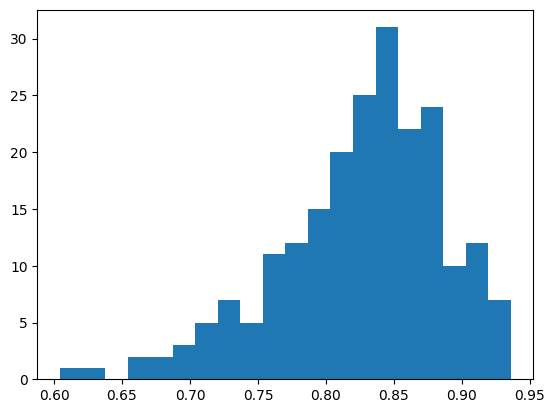

In [228]:
plt.hist(y_pred_proba[:,0],bins=20)

In [231]:
roc_auc_score(y_class_test.iloc[:,0], y_pred_proba[:, 0])


np.float64(0.6362507759155804)

In [230]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


y_pred = (y_pred_proba[:, :] > 1e-01).astype(int)
precision = precision_score(y_class_test.values, y_pred, average='micro')
recall = recall_score(y_class_test.values, y_pred, average='micro')
f1 = f1_score(y_class_test.values, y_pred, average='micro')

print(f"Precision (micro): {precision}")
print(f"Recall (micro): {recall}")
print(f"F1 Score (micro): {f1}")


Precision (micro): 0.7991071428571429
Recall (micro): 0.6258741258741258
F1 Score (micro): 0.7019607843137254


In [221]:
from sklearn.metrics import roc_auc_score

In [232]:
aucs = []
for i in range(39):
    try:
        print(roc_auc_score(y_class_test.values[:, i], y_pred_proba[:, i]))
        print(y_class_test.values[:, i].sum())
    except:
        continue

    aucs.append(roc_auc_score(y_class_test.values[:, i], y_pred_proba[:, i]))

0.6362507759155804
179
0.54
5
0.5469483568075117
2
0.5220125786163522
3
0.7232854864433812
6
nan
0
0.44182389937106914
3
0.5774647887323944
2
0.4324644549763033
4
0.5035545023696683
4
0.5271739130434783
8
0.812206572769953
2
0.16822429906542058
1
nan
0
0.4764150943396226
3
0.42957746478873243
2
0.5023474178403755
2
0.6754385964912281
6
0.6074766355140186
1
0.8286384976525822
2
0.780373831775701
1
0.11214953271028039
1
0.4976525821596244
2
0.8004694835680751
2
0.3051643192488263
2
0.3977987421383648
3
0.4672897196261683
1
0.4483568075117371
2
0.0923809523809524
5
0.4265402843601896
4
0.8037383177570093
1
0.3542857142857143
5
0.691588785046729
1
nan
0
0.5412224591329069
14
nan
0
0.8177570093457944
1
0.8474178403755869
2
0.6009389671361502
2


/home/tsakalis/ntua/nestor_celvia/.venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tsakalis/ntua/nestor_celvia/.venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tsakalis/ntua/nestor_celvia/.venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tsakalis/ntua/nestor_celvia/.venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/tsakalis/ntua/nestor_celvia/.venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:375: Undefi

(array([2., 0., 1., 0., 0., 1., 1., 0., 3., 4., 4., 4., 2., 2., 1., 2., 1.,
        0., 3., 4.]),
 array([0.09238095, 0.1301328 , 0.16788464, 0.20563649, 0.24338833,
        0.28114017, 0.31889202, 0.35664386, 0.39439571, 0.43214755,
        0.4698994 , 0.50765124, 0.54540309, 0.58315493, 0.62090677,
        0.65865862, 0.69641046, 0.73416231, 0.77191415, 0.809666  ,
        0.84741784]),
 <BarContainer object of 20 artists>)

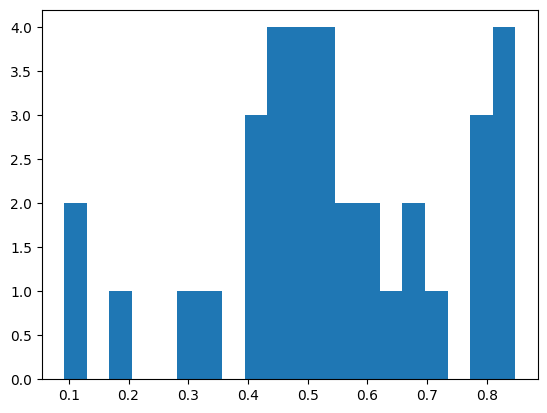

In [236]:
plt.hist(aucs, bins=20)

In [237]:
from sklearn.metrics import hamming_loss

# Example
hamming = hamming_loss(y_class_test, y_pred)
print(f"Hamming Loss: {hamming}")


Hamming Loss: 0.017674418604651163


In [120]:
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import numpy as np

X, y1 = make_classification(n_samples=10,
                            n_features=100,
                            n_informative=30,
                            n_classes=3,
                            random_state=1)
y2 = shuffle(y1, random_state=1)
y3 = shuffle(y1, random_state=2)
Y = np.vstack((y1, y2, y3)).T
n_samples, n_features = X.shape  # 10,100
n_outputs = Y.shape[1]  # 3
n_classes = 3
forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=2)
multi_target_forest.fit(X, Y).predict(X)

array([[2, 2, 0],
       [1, 2, 1],
       [2, 1, 0],
       [0, 0, 2],
       [0, 2, 1],
       [0, 0, 2],
       [1, 1, 0],
       [1, 1, 1],
       [0, 0, 2],
       [2, 0, 0]])

In [121]:
# for i in range(len(target_labels)):
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)
model.fit(X_train, y_train.values.astype(float))

# Make predictions
y_pred = model.predict(X_test)
# print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
print(r2_score(y_test, y_pred))

-0.0296022518352187


In [122]:
y_test.shape

(215, 35)

In [197]:
best_feats_idx = np.argsort(model.feature_importances_, )[-1500:]

In [198]:
num_feats = 1500

In [199]:
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import ExtraTreesRegressor

# rfe_selector = RFE(estimator=RandomForestRegressor(n_jobs=-1),
#                    n_features_to_select=num_feats,
#                    step=500,
#                    verbose=5)
# rfe_selector.fit(X_train, y_train)
# rfe_support = rfe_selector.get_support()
# # rfe_feature = X[corrs.dropna().index].loc[:,rfe_support].columns.tolist()
# # print(str(len(rfe_feature)), 'selected features')

In [ ]:
rfe_selector.__dict__


In [ ]:
rfe_support.sum()

In [202]:
params_opt = {
    'n_estimators': 800,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    # 'max_features': 'sqrt'
    'max_depth': 15,
    'random_state': 42
}

In [ ]:
# for i in range(len(target_labels)):
model2 = RandomForestRegressor(n_jobs=-1, **params_opt)
model2.fit(X_train.iloc[:, best_feats_idx], y_train.values.astype(float))

# Make predictions
y_pred = model2.predict(X_test.iloc[:, best_feats_idx])
# print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
print(r2_score(y_test, y_pred))

In [ ]:
RandomForestRegressor?

In [ ]:
# from catboost import CatBoostRegressor

# cb_reg = CatBoostRegressor(
#     objective='MultiRMSE',
#     verbose=0,
#     learning_rate=0.1,
#     n_estimators=10,
#     #    num_boost_round=10
# )
# cb_reg.fit(X_train.values, y_train)
# cb_pred = cb_reg.predict(X_test)
# # pd.DataFrame(cb_pred, columns=['Y1', 'Y2'])

In [ ]:
CatBoostRegressor?

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 150, 200, 500, 800],
    'max_depth': [None, 10, 15, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['sqrt']
    # 'max_features': [None, 'sqrt', 'log2']
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# RandomizedSearchCV for lightweight optimization
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=40,  # Number of parameter settings to sample
    cv=3,  # Number of folds for cross-validation
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=7)

# Fit the random search to the data
random_search.fit(X_train.iloc[:, best_feats_idx],
                  y_train.values)  # Flatten y_train for regression

# Best parameters and evaluation
best_model = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

# Evaluate the best model
y_pred = best_model.predict(X_test.iloc[:, best_feats_idx])
print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")


In [ ]:
y_train.shape

In [ ]:
y_pred_flat.shape

In [78]:
# import lightgbm as lgb
# from sklearn.metrics import r2_score
# import numpy as np

# correls = []
# # Assuming y_train and y_test are numpy arrays with shape (n_samples, n_targets)
# for i in range(y_train.shape[1]):  # Loop over each target variable
#     # Prepare the LightGBM dataset
#     train_data = lgb.Dataset(X_train, label=y_train.values[:, i])
#     test_data = lgb.Dataset(X_test,
#                             label=y_test.values[:, i],
#                             reference=train_data)

#     # Set parameters
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'boosting_type': 'gbdt',
#         'n_jobs': -1,
#         'verbosity': -1,
#         # 'num_leaves': 500,  # Large number of leaves to increase complexity
#         # 'max_depth': -1,  # No depth limit
#         # 'min_data_in_leaf': 1,  # Allow very small leaves
#         # 'min_child_samples': 1,  # Reduce the minimum data per child
#         # 'lambda_l1': 0,  # No L1 regularization
#         # 'lambda_l2': 0,  # No L2 regularization
#         # 'learning_rate': 0.1,  # Larger learning rate for faster overfitting
#         # 'feature_fraction': 1.0,  # Use all features
#         # 'bagging_fraction': 1.0,  # Use all data
#         # 'bagging_freq': 0,  # No bagging
#     }

#     # Train the model
#     model = lgb.train(
#         params,
#         train_data,
#         num_boost_round=100,
#         valid_sets=[train_data, test_data],
#         valid_names=['train', 'valid'],
#         #   early_stopping_rounds=10,
#         # verbose_eval=False
#     )

#     # Make predictions
#     y_pred = model.predict(X_test)

#     # Evaluate the model
#     r2 = r2_score(y_test.values[:, i], y_pred)
#     print(f"R2 score for target {i}: {r2}")
#     print(
#         np.corrcoef(y_test.values[:, i].flatten().astype(float),
#                     y_pred.flatten()))

#     correls.append(
#         np.corrcoef(y_test.values[:, i].flatten().astype(float),
#                     y_pred.flatten()))


In [206]:
correls = []
for i in range(len(target_labels)):
    correls.append(
        np.corrcoef(y_test.values[:, i].flatten().astype(float),
                    y_pred[:, i].flatten())[0, 1])

In [ ]:
sorted(correls)[::-1]

In [208]:
# for i in range(len(target_labels)):
#     model = RandomForestRegressor()
#     model.fit(X_train, y_train.values[:, i])

#     # Make predictions
#     y_pred = model.predict(X_test)
#     # print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
#     print(r2_score(y_test.values[:, i], y_pred))
#     print(
#         np.corrcoef(y_test.values[:, i].flatten().astype(float),
#                     y_pred.flatten())[0, 1])

In [ ]:
y_test.values.flatten()

In [ ]:
y_pred.flatten()

In [ ]:
y_test.shape

In [212]:
def find_vector_duplicates(array1, array2):
    # Convert each vector to a tuple for hashable comparison
    set1 = {tuple(vec) for vec in array1}
    duplicates = [vec for vec in array2 if tuple(vec) in set1]
    return duplicates

In [ ]:
gene_names.iloc[genes][0].values

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the plot (example data, replace with actual values)
sort_idx = np.argsort(correls)  #[::-1]
genes = np.array(target_labels)[sort_idx]

# Plotting
y_pos = np.arange(len(genes))

plt.figure(figsize=(10, 8))
plt.barh(y_pos - 0.2,
         np.array(correls)[sort_idx],
         height=0.4,
         label='Pearson',
         color='blue',
         alpha=0.7)
# plt.barh(y_pos + 0.2, spearman, height=0.4, label='Spearman', color='orange', alpha=0.7)

plt.yticks(y_pos, gene_names.iloc[genes][0].values)
plt.xlabel("Correlation Coefficient")
plt.title("Correlation Pearson")
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()


In [ ]:
y_test.shape

In [ ]:
np.corrcoef(y_test.T, y_pred.T)

In [ ]:
pca_vecs = pca.fit_transform(latent_vecs)

In [ ]:
pca.explained_variance_ratio_.sum()

In [ ]:
pca.get_covariance()

In [ ]:
np.corrcoef(pca_vecs[:, 0], [pca_vecs[:, 1]])

In [ ]:
plt.scatter(pca_vecs[:, 0], [pca_vecs[:, 1]])
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)